In [1]:
import ROOT, os, sys, glob
import numpy as np
import math
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed
from array import array

ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.2.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout

In [3]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.0.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_JPsiToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root']

In [4]:
def Normal_h(h1,h2):
    h_p = h1.Clone()
    h_p.Scale(1./h2.Integral())
    return h_p;

In [5]:
def Efficiency_plotter(file_name):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second]));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second]));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0,50),"TkDiMu_mass")

    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
####################################################################################################################################################################    
    
    def indexSelect(rdf):
        rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
        #rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
        rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
        return rdf;

    rdf_idxSel = indexSelect(rdf_genDiMu)
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

    entries_idx_pair = rdf_idxSel.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.)&&({name}DiMu_eta <= 2) && (TkDiMu_hwIsoSumAp<=1.5) && (TkDiMu_hwIsoSum<=1.5)")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    rdf_Tk_selFeat = select_ind("Tk",rdf_idxSel)
    #rdf_selFeat = select_ind("Gen", rdf_Tk_selFeat)
    
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0,50),"TkDiMu_selMass")

    
    def select_idx_tk(rdf):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 2.) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <=2)&& (TkDiMu_IdxhwIsoSum<=1.5) && (TkDiMu_IdxhwIsoSumAp<=1.5) ")                    
        rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselEta",f"TkDiMu_IdxEta[TkDiMu_Idx_good]")

        return rdf;
    
    rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    
    entries_selIdx_pair = rdf_Tk_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
    
    h1 = hGoodIdxTkPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxTkPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1,h2=h2,h3=h3,h_TkDiMu_mass =h_TkDiMu_mass,h_TkDiMu_selMass=h_TkDiMu_selMass);
#     c, pad1, pad2 = createCanvasPads()
#     pad1.cd()
#     h1.Draw()
#     h2.Draw("same")
#     # to avoid clipping the bottom zero, redraw a small axis
#     h1.GetYaxis().SetLabelSize(0.0)
#     axis =ROOT.TGaxis(-5, 20, -5, 220, 20, 220, 510, "")|
#     axis.SetLabelFont(43)
#     axis.SetLabelSize(15)
#     axis.Draw()
#     pad2.cd()
#     h3.Draw("ep")
#     c.Draw()


#normalisation:
#      TH1*h1 = (TH1*)(h->Clone("h1"));
#      h1->Scale(1./h1->Integral(), "width");
#      h1->Draw();
    

In [6]:
def Efficiency_plotter_new(file_name):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second]));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second]));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0,50),"TkDiMu_mass")

    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
####################################################################################################################################################################    
    
    def indexSelect(rdf):
        rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
        #rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
        rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
        return rdf;

    rdf_idxSel = indexSelect(rdf_genDiMu)
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

    entries_idx_pair = rdf_idxSel.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>0.25*{name}DiMu_mass)&&({name}DiMu_eta <= 2) && (TkDiMu_hwIsoSumAp<=1.5) && (TkDiMu_hwIsoSum<=1.5)")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    rdf_Tk_selFeat = select_ind("Tk",rdf_idxSel)
    #rdf_selFeat = select_ind("Gen", rdf_Tk_selFeat)
    
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0,50),"TkDiMu_selMass")

    
    def select_idx_tk(rdf):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 0.25*TkDiMu_IdxMass) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <=2)&& (TkDiMu_IdxhwIsoSum<=1.5) && (TkDiMu_IdxhwIsoSumAp<=1.5) ")                    
        rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselEta",f"TkDiMu_IdxEta[TkDiMu_Idx_good]")

        return rdf;
    
    rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    
    entries_selIdx_pair = rdf_Tk_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
    
    h1 = hGoodIdxTkPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxTkPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1,h2=h2,h3=h3,h_TkDiMu_mass =h_TkDiMu_mass,h_TkDiMu_selMass=h_TkDiMu_selMass);
#     c, pad1, pad2 = createCanvasPads()
#     pad1.cd()
#     h1.Draw()
#     h2.Draw("same")
#     # to avoid clipping the bottom zero, redraw a small axis
#     h1.GetYaxis().SetLabelSize(0.0)
#     axis =ROOT.TGaxis(-5, 20, -5, 220, 20, 220, 510, "")|
#     axis.SetLabelFont(43)
#     axis.SetLabelSize(15)
#     axis.Draw()
#     pad2.cd()
#     h3.Draw("ep")
#     c.Draw()


#normalisation:
#      TH1*h1 = (TH1*)(h->Clone("h1"));
#      h1->Scale(1./h1->Integral(), "width");
#      h1->Draw();
    

In [18]:

# colour = [ROOT.kRed, ROOT.kBlue -4, ROOT.kOrange + 8, ROOT.kGreen+1]

# for i, m in enumerate(["2", "5", "10", "25"]):
#     data = Efficiency_plotter(f"l1MuNano_HAHM_ZdToMuMu_M{m}_PU200.125X_v0.1.root")
#     h_add = Normal_h(data['h2'],data['h2'])
#     leg.AddEntry(h_add,f"Signal of dark photon mass = {m}","f")
#     h_add.SetLineColor(colour[i])
#     hs.Add(h_add)


# #y.SetTitle("Number of pairs (normalised)")


# c = ROOT.TCanvas("")
# c.cd()
# hs.Draw("hist nostack")
# hs.SetTitle("Normalised histogram of index matched muon pairs with respect to mass")
# hs.GetXaxis().SetTitle("mass of dark photon(GeV)")
# #x.SetTitle("mass of dark photon(GeV)")
# hs.GetYaxis().SetTitle("Number of pairs (normalised)")

# c.Draw()


****************************************
Minimizer is Minuit / Migrad
Chi2                      =  7.34937e-11
NDf                       =            5
Edm                       =  6.56081e-14
NCalls                    =           59
Constant                  =     -5.64094   +/-   0.0236224   
Slope                     =    -0.347911   +/-   0.0023629   


Info in <TCanvas::Print>: png file full_background.png has been created


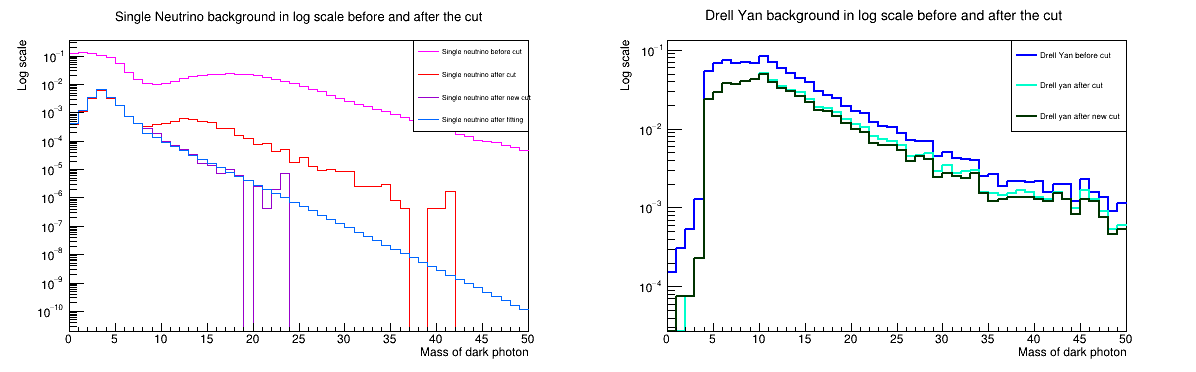

In [19]:
#Forming a stack of histograms

leg_1 = ROOT.TLegend(0.9,0.65,0.7,0.9)
leg_2 = ROOT.TLegend(0.9,0.65,0.7,0.9)

#leg_1.SetHeader("","C")

hs = ROOT.THStack("hs","Single Neutrino background in log scale before and after the cut;Mass of dark photon;Log scale")
hs_1 = ROOT.THStack("hs_1","Drell Yan background in log scale before and after the cut;Mass of dark photon;Log scale")



data_bg_1 = Efficiency_plotter("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root")
data_bg_1_new = Efficiency_plotter_new("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root")


h_add_bg1 = Normal_h(data_bg_1['h_TkDiMu_mass'].GetPtr(),data_bg_1['h_TkDiMu_mass'].GetPtr())
h_add_bg1.SetLineColor(ROOT.kMagenta)
hs.Add(h_add_bg1)

h_add_bg1_sel = Normal_h(data_bg_1['h_TkDiMu_selMass'].GetPtr(),data_bg_1['h_TkDiMu_mass'].GetPtr())
h_add_bg1_sel.SetLineColor(ROOT.kRed)
hs.Add(h_add_bg1_sel)

#kViolet-1 this is new cut on Single Neutrino
h_add_bg1_sel_new = Normal_h(data_bg_1_new['h_TkDiMu_selMass'].GetPtr(),data_bg_1_new['h_TkDiMu_mass'].GetPtr())
h_add_bg1_sel_new.SetLineColor(ROOT.kViolet-1)
hs.Add(h_add_bg1_sel_new)

#fitting
h_add_bg1_sel_new.Fit("expo","W","",12,20)
func = h_add_bg1_sel_new.GetListOfFunctions().At(0)
func.SetRange(8.,50.)

h_bg1_cloned = h_add_bg1_sel_new.Clone() 
    # loop over the bins
for b in range(1, h_bg1_cloned.GetNbinsX()+1):
   # get the x axis value for it
    xval = h_bg1_cloned.GetXaxis().GetBinCenter(b)
   # at high mass, replace bin content with function value
    if xval > 8.: 
        h_bg1_cloned.SetBinContent(b, func.Eval(xval))
        
h_bg1_cloned.SetLineColor(ROOT.kAzure-3)
hs.Add(h_bg1_cloned)

leg_1.AddEntry(h_add_bg1,"Single neutrino before cut","l")
leg_1.AddEntry(h_add_bg1_sel,"Single neutrino after cut","l")
leg_1.AddEntry(h_add_bg1_sel_new,"Single neutrino after new cut","l")
leg_1.AddEntry(h_bg1_cloned,"Single neutrino after fitting","l")




data_bg_2 = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root")
data_bg_3 = Efficiency_plotter("l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.2.root")

data_bg_2_new = Efficiency_plotter_new("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root")
data_bg_3_new = Efficiency_plotter_new("l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.2.root")

h_comb_DY = data_bg_2['h2'].Clone()
h_comb_DY.Add(data_bg_3['h2'])
h_add_bg2 = Normal_h(h_comb_DY,h_comb_DY)
h_add_bg2.SetLineColor(ROOT.kBlue)
hs_1.Add(h_add_bg2)


h_comb_DY_sel = data_bg_2['h1'].Clone()
h_comb_DY_sel.Add(data_bg_3['h1'])
h_add_bg2_sel = Normal_h(h_comb_DY_sel,h_comb_DY)
h_add_bg2_sel.SetLineColor(ROOT.kTeal)
hs_1.Add(h_add_bg2_sel)

h_comb_DY_sel_new = data_bg_2_new['h1'].Clone()
h_comb_DY_sel_new.Add(data_bg_3_new['h1'])
h_add_bg2_sel_new = Normal_h(h_comb_DY_sel_new,h_comb_DY)
h_add_bg2_sel_new.SetLineColor(ROOT.kGreen+4)
hs_1.Add(h_add_bg2_sel_new)

leg_2.AddEntry(h_add_bg2,"Drell Yan before cut","l")
leg_2.AddEntry(h_add_bg2_sel,"Drell yan after cut","l")
leg_2.AddEntry(h_add_bg2_sel_new,"Drell yan after new cut","l")



c = ROOT.TCanvas("","",1200,400)
c.Divide(2,1)
c.cd(1)
hs.Draw("hist nostack")
leg_1.Draw()
c.cd(1).SetLogy(True)

c.cd(2)
hs_1.Draw("hist nostack")
leg_2.Draw()
c.cd(2).SetLogy(True)

# # for the legend
# leg.AddEntry(h_add_bg1,"Single neutrino background before cut","f")
# leg.AddEntry(h_add_bg1_sel,"Single neutrino background after cut","f")
# leg.AddEntry(h_add_bg2,"Drell Yan background before cut","f")
# leg.AddEntry(h_add_bg2_sel,"Drell Yan background after cut","f")

#c.SetLogy(True)
#leg.Draw()
c.Draw()
c.SaveAs("full_background.png")





In [ ]:
# #Forming a stack of histograms

# leg_sel = ROOT.TLegend(0.9,0.75,0.6,0.9)
# leg_sel.SetHeader("Signal and background","C")

# hs_sel = ROOT.THStack("hs","")
# #colour = [ROOT.kRed, ROOT.kBlue -4, ROOT.kOrange + 8, ROOT.kGreen+1]

# for i, m in enumerate(["2", "5", "10", "25"]):
#     data_sel = Efficiency_plotter(f"l1MuNano_HAHM_ZdToMuMu_M{m}_PU200.125X_v0.1.root")
#     h_add_sel = Normal_h(data_sel['h1'],data_sel['h2'])
#     leg_sel.AddEntry(h_add_sel,f"Signal after selection cut for dark photon mass = {m}","f")
#     h_add_sel.SetLineColor(colour[i])
#     hs_sel.Add(h_add_sel)


# #y.SetTitle("Number of pairs (normalised)")


# c = ROOT.TCanvas("")
# c.cd()
# hs_sel.Draw("hist nostack")
# hs_sel.SetTitle("Normalised histogram of index matched muon pairs with respect to mass after selection")
# hs_sel.GetXaxis().SetTitle("mass of dark photon(GeV)")
# #x.SetTitle("mass of dark photon(GeV)")
# hs_sel.GetYaxis().SetTitle("Number of pairs (normalised)")

# c.Draw()

In [ ]:
# #data_bg_1_sel = Efficiency_plotter("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root")
# h_add_bg1_sel = Normal_h(data_bg_1['h_TkDiMu_selMass'].GetPtr(),data_bg_1['h_TkDiMu_mass'].GetPtr())
# h_add_bg1_sel.SetLineColor(ROOT.kMagenta)
# hs_sel.Add(h_add_bg1_sel)

# #data_bg_2_sel = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root")
# h_add_bg2_sel = Normal_h(data_bg_1['h1'],data_bg_1['h2'])
# h_add_bg2_sel.SetLineColor(ROOT.kTeal)
# hs_sel.Add(h_add_bg2_sel)

# c = ROOT.TCanvas("")
# c.cd()
# hs_sel.Draw("hist nostack")

# # for the legend
# leg_sel.AddEntry(h_add_bg1,"Single neutrino background after selection","f")
# leg_sel.AddEntry(h_add_bg2,"Drell Yan background after selection","f")

# leg_sel.Draw()
# c.Draw()
# c.SaveAs("after_selection_on_signal_and_back.png")

In [ ]:
#rdf_25.Describe()
#h3 = h3.GetPtr()

In [ ]:
# def createCanvasPads():
#         c = ROOT.TCanvas("c", "canvas", 800, 800)
#         # Upper histogram plot is pad1
#         pad1 =ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
#         pad1.SetBottomMargin(0)  # joins upper and lower plot
#         pad1.SetGridx()
#         pad1.Draw()
#         # Lower ratio plot is pad2
#         c.cd()  # returns to main canvas before defining pad2
#         pad2 =ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
#         pad2.SetTopMargin(0)  # joins upper and lower plot
#         pad2.SetBottomMargin(0.2)
#         pad2.SetGridx()

#         pad2.Draw()

#         return c, pad1, pad2;

In [ ]:
# # c = ROOT.TCanvas()
# # c.cd()
# # h3.Draw("hist c plc")
# # c.Draw()
# c, pad1, pad2 = createCanvasPads()
# pad1.cd()
# h1.Draw()
# h2.Draw("same")
# # to avoid clipping the bottom zero, redraw a small axis
# h1.GetYaxis().SetLabelSize(0.0)
# axis =ROOT.TGaxis(-5, 20, -5, 220, 20, 220, 510, "")
# axis.SetLabelFont(43)
# axis.SetLabelSize(15)
# axis.Draw()
# pad2.cd()
# h3.Draw("hist c plc")
# c.Draw()

In [ ]:
# filename_list = ["l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root","l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root","l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root"]

In [ ]:
# h1 = {}
# h2 = {}
# h3 = {}

# for filename in enumerate(filename_list):
#     print(filename)
#     fname = filename[1]
#     [h1[fname],h2[fname],h3[fname],e1,e2] = Efficiency_plotter(fname)
#     c = ROOT.TCanvas()
#     c.cd()
#     h3[fname].Draw("hist c plc")
#     c.Draw()